# **Duplicate Questions with the Quora Dataset**

This notebook presents the implementation of a text classification model using a Siamese network with a bidirectional LSTM layer to detect similar questions. Its purpose is to determine if two questions are paraphrases of each other using the [Quora Question Pairs dataset](https://huggingface.co/datasets/nyu-mll/glue/viewer/qqp/test).

For a more robust implementation, please visit my upcoming [notebook](https://github.com/JersonGB22/TextClassification-TensorFlow/blob/main/models_transformers/DuplicateQuestions_BERT_Quora.ipynb), where a Transformer network is implemented to classify duplicate Quora questions, achieving better results.

### **Imports**

In [2]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML

### **Parameters**

In [ ]:
epochs = 20
batch_size = 256
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
vocab_size = 50000 #Including padding and unknown tokens
embedding_dim = 128

### **Load and Preprocess the Dataset**

In [ ]:
# Load the dataset from the Hugging Face's 'datasets' library
df = load_dataset("quora")["train"].to_pandas()

# Extract question pairs without considering empty strings
df["question_1"] = df.questions.apply(lambda x: x["text"][0] if len(x["text"][0]) > 0 else None)
df["question_2"] = df.questions.apply(lambda x: x["text"][1] if len(x["text"][1]) > 0 else None)

# Remove the 'questions' column
df = df.drop(columns=["questions"])

# Remove missing records
df = df.dropna().reset_index(drop=True)

# Change the data type of the 'is_duplicate' column
df["is_duplicate"] = df.is_duplicate.astype(np.float32)
df

,is_duplicate,question_1,question_2
0,0.0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,0.0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,0.0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,0.0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,0.0,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?
...,...,...,...
404283,0.0,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...
404284,1.0,Do you believe there is life after death?,Is it true that there is life after death?
404285,0.0,What is one coin?,What's this coin?
404286,0.0,What is the approx annual cost of living while...,I am having little hairfall problem but I want...


In [ ]:
print(df.info(), "\n")
df[df.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404288 entries, 0 to 404287
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   is_duplicate  404288 non-null  float32
 1   question_1    404288 non-null  object 
 2   question_2    404288 non-null  object 
dtypes: float32(1), object(2)
memory usage: 7.7+ MB
None 



,is_duplicate,question_1,question_2


**Undersampling**

Since the dataset is unbalanced and non-duplicate questions are predominant, it's necessary to perform undersampling to have an equal amount of duplicate and non-duplicate questions, thus improving the training process.

In [ ]:
print(df.is_duplicate.value_counts(), "\n")
min_size = df.is_duplicate.value_counts().min()
min_size

is_duplicate
0.0    255025
1.0    149263
Name: count, dtype: int64 



149263

In [ ]:
df_minority = df[df.is_duplicate == 1]
df_majority = df[df.is_duplicate == 0]
df_majority = df_majority.sample(min_size, random_state=SEED)
df = pd.concat([df_majority, df_minority], axis=0)

del df_minority, df_majority

df.is_duplicate.value_counts()

is_duplicate
0.0    149263
1.0    149263
Name: count, dtype: int64

**Splitting the dataframe into training (90%), validation (5%) y testing (5%) sets**

In [ ]:
df_train, df_val_test = train_test_split(df, test_size=0.1, random_state=SEED, stratify=df.is_duplicate)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=SEED, stratify=df_val_test.is_duplicate)

del df, df_val_test #Remove to free memory

print(len(df_train), len(df_val), len(df_test), "\n")

# Thanks to the 'stratify' argument, the distribution is preserved
print(df_train.is_duplicate.value_counts())
print(df_val.is_duplicate.value_counts())
print(df_test.is_duplicate.value_counts())

268673 14926 14927 

is_duplicate
1.0    134337
0.0    134336
Name: count, dtype: int64
is_duplicate
1.0    7463
0.0    7463
Name: count, dtype: int64
is_duplicate
0.0    7464
1.0    7463
Name: count, dtype: int64


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ((df_train.question_1.values, df_train.question_2.values), df_train.is_duplicate.values)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ((df_val.question_1.values, df_val.question_2.values), df_val.is_duplicate.values)
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ((df_test.question_1.values, df_test.question_2.values), df_test.is_duplicate.values)
)

train_dataset = train_dataset.shuffle(buffer_size, seed=SEED).batch(batch_size).prefetch(AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
# Viewing a training batch
for (q1, q2), la in train_dataset.take(1):
  print(q1.numpy()[:5])
  print(q2.numpy()[:5], "\n")
  print(la.numpy()[:5])

[b'Is Durex ultra thin condom safe?'
 b"Why didn't other European imperialist follow British to build their colony on Indian vast continent?"
 b'How does the ban on 500 and 1000 rupee notes helps to identify black money and corruption?'
 b'Is China authoritarian or totalitarian?'
 b'Is ethical hacking a good career choice in India?']
[b'How safe is durex ultra thin condoms?'
 b'Of all European power, why did only the British succeeded in setting up vast colonial rule in Indian subcontinent?'
 b'How can Modi government prevent black money by discontinuing 500 and 1000 notes?'
 b'Is China a totalitarian state?'
 b'What is the scope of Ethical Hacking in India?'] 

[1. 1. 1. 0. 0.]


**Text Encoder Creation**

Text processing utilizes the ``TextVectorization`` layer, which encodes text into indices by frequency order (following the padding token and the unknown token), considering up to ``vocab_size``. Index tensors are padded with zeros up to the longest sequence in the batch (unless you set a fixed value for ``output_sequence_length``).

In [ ]:
tf.random.set_seed(SEED)

encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size,
                                            standardize="lower_and_strip_punctuation")
encoder.adapt(np.concatenate([df_train.question_1, df_train.question_2], axis=0))
vocab = np.array(encoder.get_vocabulary())

del df_train, df_val

In [ ]:
print(encoder.vocabulary_size())
vocab[:10]

50000


array(['', '[UNK]', 'the', 'what', 'is', 'how', 'i', 'to', 'a', 'in'],
      dtype='<U93')

In [ ]:
# Visualizing tokenization
encoded_texts = encoder(q2)[:3].numpy()
print(encoded_texts.shape)
encoded_texts

(3, 37)


array([[    5,   297,     4, 27172,  7369,  4146,  7143,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [   11,    82,  1602,   392,    17,    56,   194,     2,   817,
        11616,     9,  3208,   122,  8297,  8256,  1649,     9,    81,
         9213,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    5,    14,   344,   220,  1063,   141,    60,    57,  2948,
          104,    13,   105,    97,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])

In [ ]:
# Visualizing text processing
print(q2[1].numpy().decode("utf-8"), "\n")
print(" ".join(vocab[encoded_texts[1]]))

Of all European power, why did only the British succeeded in setting up vast colonial rule in Indian subcontinent? 

of all european power why did only the british succeeded in setting up vast colonial rule in indian subcontinent                  


### **Build the Model**

The model's architecture is a siamese network, a type of neural network that uses the same weights while working together on two different input vectors to calculate comparable output vectors.

Questions enter the `TextVectorization` layer, which preprocesses them and converts them into tokens. Then, they pass into the `Embedding` layer, which vectorizes each token and reduces its dimensionality from `vocab_size` to `embedding_dim`, thereby representing the information compactly. After this, they pass through a ``bidirectional LSTM`` layer, which allows the neural network to access both the past and future of the sequence, significantly improving performance on tasks that require a deep understanding of context. Finally, the vectors pass through the custom `EuclideanDistance` layer to calculate the similarity between each pair of questions. A custom layer was needed to compute the Euclidean distance because [Lambda layers have serialization issues](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda).

The custom loss function used is [Contrastive Loss](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf) with a margin of 1.0. Contrastive Loss is suitable for this type of task because it measures the similarity between two vectors and adjusts the model to minimize the distance between similar vectors while maximizing the distance between dissimilar vectors. The custom metric used is accuracy, but unlike conventional accuracy, it considers a prediction positive if the predicted value is less than or equal to the set threshold.

In [ ]:
# Custom layer to calculate the Euclidean distance between two tensors
@tf.keras.saving.register_keras_serializable()
class EuclideanDistance(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()

  def call(self, vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=-1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))


# Custom function to calculate contrastive loss
def contrastive_loss(y_true, y_pred, margin=1.0):
  positive_loss = y_true * tf.square(y_pred)
  negative_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0.0))
  return positive_loss +  negative_loss


# Custom function to calculate accuracy
def accuracy(y_true, y_pred, threshold=0.5):
  y_pred = tf.cast(y_pred <= threshold, dtype=tf.float32)
  return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32))

In [ ]:
def siamese_model():
  base = tf.keras.Sequential([
      encoder,
      tf.keras.layers.Embedding(
          input_dim=encoder.vocabulary_size(),
          output_dim=embedding_dim,
          mask_zero=True, #To handle variable sequence lengths
      ),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))
  ])

  input_1 = tf.keras.Input(shape=(), dtype=tf.string)
  input_2 = tf.keras.Input(shape=(), dtype=tf.string)

  branch_1 = base(input_1)
  branch_2 = base(input_2)
  euclidean_layer = EuclideanDistance()([branch_1, branch_2])

  model = tf.keras.Model(inputs=[input_1, input_2], outputs=euclidean_layer)

  return model

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(SEED) #For reproducibility

model = siamese_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256)                  6663168   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 euclidean_distance (Euclid  (None, 1)                    0         ['sequential[0][0]',      

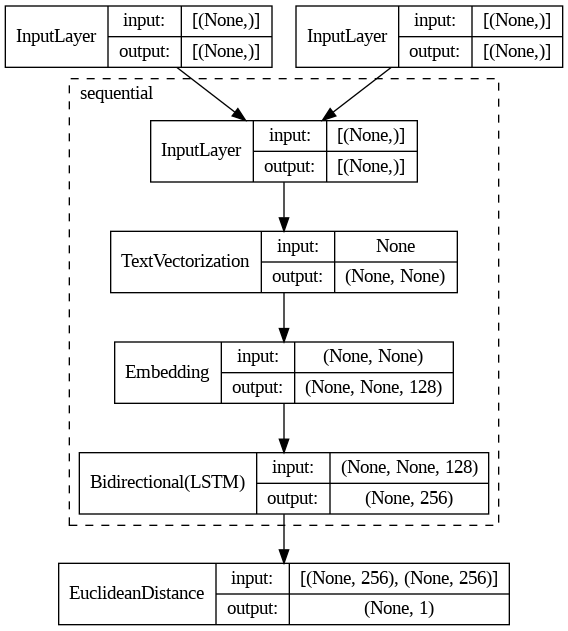

In [ ]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, expand_nested=True)

### **Compile and Train the Model**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=contrastive_loss,
    metrics=[accuracy]
)

# Callback to stop training early if validation accuracy does not improve for 3 epochs.
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True
)

In [ ]:
tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])

Epoch 1/20
1050/1050 [==============================] - 75s 57ms/step - loss: 0.1690 - accuracy: 0.7641 - val_loss: 0.1417 - val_accuracy: 0.8114
Epoch 2/20
1050/1050 [==============================] - 33s 32ms/step - loss: 0.1114 - accuracy: 0.8597 - val_loss: 0.1339 - val_accuracy: 0.8270
Epoch 3/20
1050/1050 [==============================] - 33s 32ms/step - loss: 0.0907 - accuracy: 0.8931 - val_loss: 0.1351 - val_accuracy: 0.8277
Epoch 4/20
1050/1050 [==============================] - 31s 30ms/step - loss: 0.0792 - accuracy: 0.9113 - val_loss: 0.1415 - val_accuracy: 0.8309
Epoch 5/20
1050/1050 [==============================] - 32s 31ms/step - loss: 0.0713 - accuracy: 0.9234 - val_loss: 0.1418 - val_accuracy: 0.8316
Epoch 6/20
1050/1050 [==============================] - 30s 29ms/step - loss: 0.0640 - accuracy: 0.9335 - val_loss: 0.1491 - val_accuracy: 0.8307
Epoch 7/20
1050/1050 [==============================] - 30s 29ms/step - loss: 0.0601 - accuracy: 0.9391 - val_loss: 0.1535 -

**Save model**

In [ ]:
drive.mount("/content/drive/")
trained_model_path = "/content/drive/MyDrive/models/DuplicateQuestions_LSTM_Quora.keras"

In [ ]:
model.save(trained_model_path)

### **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(val_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.06709015369415283, 0.9291483163833618]
[0.1417534202337265, 0.8315881490707397]
[0.13498403131961823, 0.8361302614212036]


The training set achieves an accuracy of 93%, while the validation set accuracy is 83.2%, and the test set accuracy is 83.6%. If we were to continue training for more epochs, the training set accuracy would increase to 100%, while that of the validation and test sets would decrease. This suggests that the model is good but suffers from overfitting, despite the training set being quite large, the best hyperparameters being chosen, and a callback being used to stop training when the validation accuracy does not improve for 3 epochs, in order to reduce overfitting. To achieve better results, it would be advisable to use more robust architectures such as transformer networks, as the task of detecting duplicate questions is more complex compared to sentiment analysis.

In [6]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = metric.capitalize()

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [7]:
plot_metrics(metric="accuracy")
plot_metrics()

**Images for GitHub**

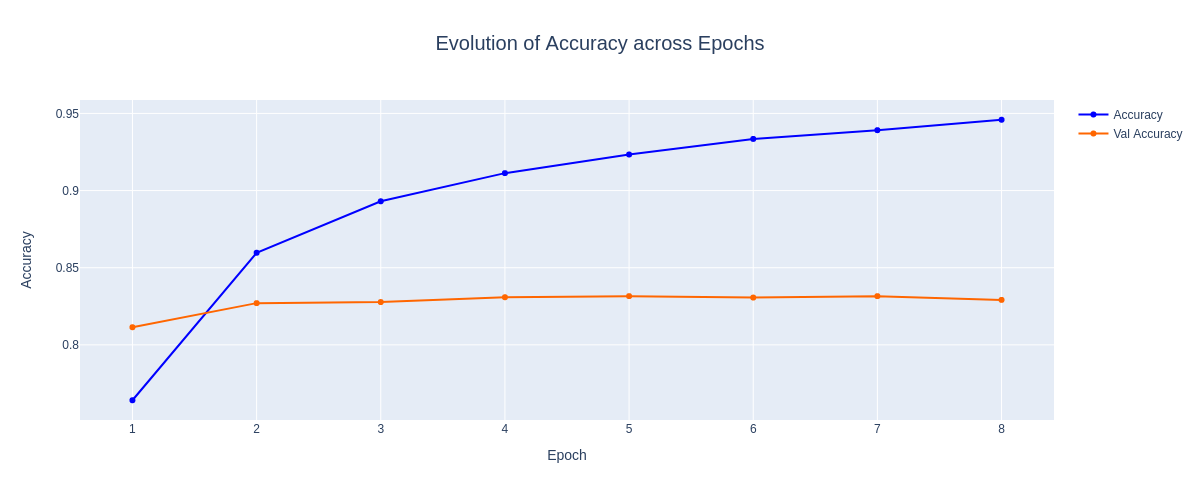

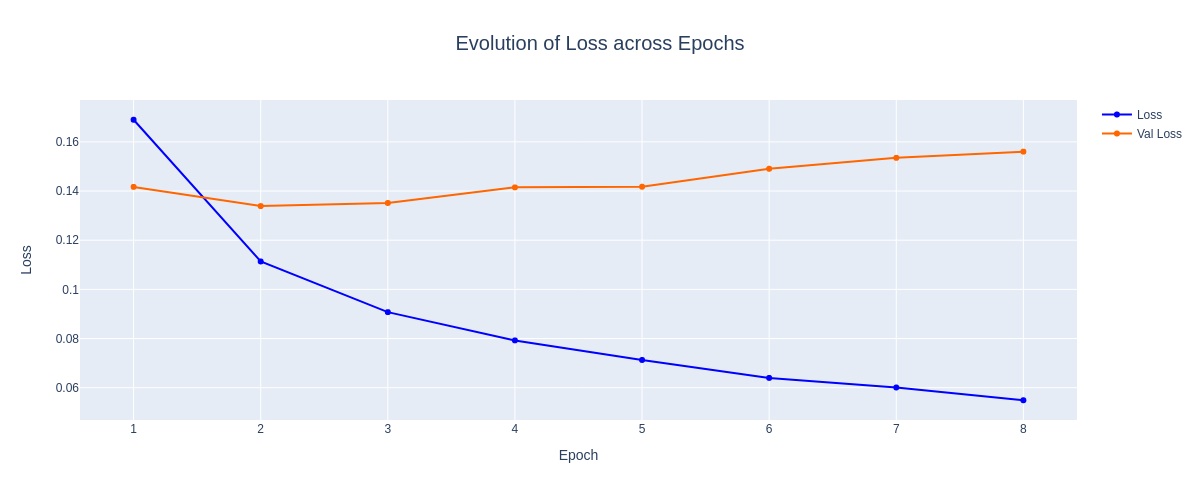

In [8]:
plot_metrics(renderer="png", metric="accuracy")
plot_metrics(renderer="png")

**Confusion Matrix**

Accuracy: 0.8367387954712936
F1 Score: 0.8394492390803082
Total not duplicates:  7464 ; Total duplicates:  7463
[18.01982851 14.63218545]


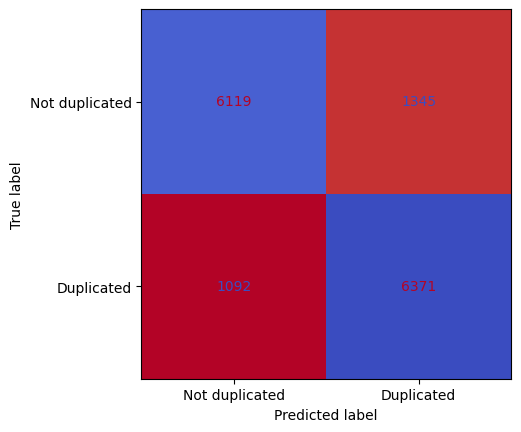

In [ ]:
threshold = 0.5
labels_test = df_test.is_duplicate.values.astype(np.int32)

labels_test_pred = model.predict(test_dataset, verbose=0).squeeze()
labels_test_pred = (labels_test_pred <= threshold).astype(np.int32)
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred)}")

cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Not duplicated", "Duplicated"])
cmd.plot(colorbar=False, cmap="coolwarm_r");

print("Total not duplicates: ", np.bincount(labels_test)[0], "; Total duplicates: ", np.bincount(labels_test)[1])
print(((np.bincount(labels_test) - np.diag(cm)) / np.bincount(labels_test)) * 100)

It is observed that the model has a slightly harder time predicting non-duplicate questions, as reflected in a false positive rate of 18%, compared to the false negatives of 14.6%. Both the accuracy and F1 score of the model are similar, meaning the model is performing well overall in classifying the target classes without unbalanced predictions.

### **Predictions with the trained model**

In [ ]:
# Custom Objects

@tf.keras.saving.register_keras_serializable()
class EuclideanDistance(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()

  def call(self, vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=-1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))


def contrastive_loss(y_true, y_pred, margin=1.0):
  positive_loss = y_true * tf.square(y_pred)
  negative_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0.0))
  return positive_loss +  negative_loss


def accuracy(y_true, y_pred, threshold=0.5):
  y_pred = tf.cast(y_pred <= threshold, dtype=tf.float32)
  return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32))

In [ ]:
# Load model
tf.keras.backend.clear_session()

model = tf.keras.models.load_model(
    trained_model_path,
    custom_objects={"contrastive_loss": contrastive_loss, "accuracy": accuracy}
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256)                  6663168   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 euclidean_distance (Euclid  (None, 1)                    0         ['sequential[0][0]',      

In [ ]:
def predict_duplicate(questions_1, questions_2, labels, random=True):
  label_names = ["Non-Duplicate Question", "Duplicate Question"]
  label_colors = ["green", "red"]

  indice = np.random.choice(len(questions_1)) if random else 0
  q1 = np.array([questions_1[indice]])
  q2 = np.array([questions_2[indice]])

  label_pred = model.predict([q1, q2], verbose=0).squeeze()
  label_pred = (label_pred <= 0.5).astype(np.int32)

  html_content = f"""
    <b>Question 1:</b> {q1[0]}<br><br>
    <b>Question 2:</b> {q2[0]}<br><br>
    <b>True Label: <span style="color: {label_colors[labels[indice]]}">{label_names[labels[indice]]}</span></b><br>
    <b>Predicted Label: <span style="color: {label_colors[label_pred]}">{label_names[label_pred]}</span></b>
    """
  display(HTML(html_content))

**Test Dataset**

In [ ]:
questions_1, questions_2 = df_test.question_1.values, df_test.question_2.values
labels = df_test.is_duplicate.values.astype(np.int32)

In [ ]:
predict_duplicate(questions_1, questions_2, labels, random=False)

In [ ]:
predict_duplicate(questions_1, questions_2, labels)

In [ ]:
# Long Questions
predict_duplicate(questions_1, questions_2, labels)

In [ ]:
# Long Questions
predict_duplicate(questions_1, questions_2, labels)

In [ ]:
# Incorrect Prediction
predict_duplicate(questions_1, questions_2, labels)

**Other Questions**

In [ ]:
q1 = ["How can I lose weight fast?"]
q2 = ["What are some effective weight loss strategies?"]
label = [1]

predict_duplicate(q1, q2, label)

In [ ]:
q1 = ["What is the difference between a quadratic equation and a cubic equation?"]
q2 = ["How do you solve a cubic equation?"]
label = [0]

predict_duplicate(q1, q2, label)

In [ ]:
# More challenging questions
q1 = ["What are the most effective methods for reducing carbon emissions in urban areas to combat climate change?"]
q2 = ["How can cities reduce carbon emissions to mitigate the impacts of climate change?"]
label = [1]

predict_duplicate(q1, q2, label)

In [ ]:
# More challenging questions
q1 = ["What are the key differences between traditional Chinese medicine and modern Western medicine?"]
q2 = ["How do Eastern and Western medical practices differ in their approaches to healthcare?"]
label = [0]

predict_duplicate(q1, q2, label)

**Conclusion:** The siamese network model proves to be highly effective in predicting question duplication, even when questions are complex and/or lengthy. Although the achieved accuracy in the evaluation and test set is 83%, the model has been trained on a large amount of data, surpassing 260k question pairs, allowing it to generalize effectively. To mitigate overfitting and achieve even better results, the adoption of attention-based models such as transformers is recommended, particularly those pretrained by Hugging Face on millions of data.